In [2]:
%matplotlib notebook

import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import piff
from piff import Star
import fitsio
from piff.des.decaminfo import DECamInfo

dinfo = DECamInfo()



# use file made in OptAtmo-makeStarSummary

This notebook was not finished - need to clean up

In [4]:
outfile = "/nfs/slac/g/ki/ki06/roodman/Piff/y1_500_i_shape_mode_nolincoma.fits"
af = fitsio.FITS(outfile)
print(af['psf_stars'])

# list variables for train stars
t = af['psf_stars'].read()



  file: /nfs/slac/g/ki/ki06/roodman/Piff/y1_500_i_shape_mode_nolincoma.fits
  extension: 1
  type: BINARY_TBL
  extname: psf_stars
  rows: 6587427
  column info:
    x                   f8  
    y                   f8  
    u                   f8  
    v                   f8  
    chipnum             f8  
    ra                  f8  
    dec                 f8  
    e0                  f8  
    e1                  f8  
    e2                  f8  
    se0                 f8  
    se1                 f8  
    se2                 f8  
    fov_x               f8  
    fov_y               f8  
    pix_area            f8  
    atmo_size           f8  
    atmo_g1             f8  
    atmo_g2             f8  
    optics_L0           f8  
    optics_size         f8  
    optics_g1           f8  
    optics_g2           f8  
    model_e0            f8  
    model_e1            f8  
    model_e2            f8  


In [7]:
# plot variables for stars
f,axa = plt.subplots(4,4,figsize=(12,10))
ax = axa.flatten()

ax[0].scatter(t['x'][:],t['y'][:],marker='.',s=0.1)
ax[0].set_title('y vs. x')
ax[1].scatter(t['u'][:],t['v'][:],marker='.',s=0.1)
ax[1].set_title('v vs. u')
ax[2].hist(t['chipnum'][:],bins=62)
ax[2].set_title('Chipnum')

#ax[3].hist(t['snr'][:],bins=100)
#ax[3].set_title('snr')
ax[4].hist(t['e0'][:],bins=100)
ax[4].set_title('e0')
ax[5].hist(t['e1'][:],bins=100)
ax[5].set_title('e1')
ax[6].hist(t['e2'][:],bins=100)
ax[6].set_title('e2')
ax[7].hist(t['pix_area'],bins=100)
ax[7].set_title('pixel size')

# why isn't mag present?
#ax[10].hist(np.log10(t['flux'][:]),bins=100)
#ax[10].set_title('log10 flux')
ax[11].hist(t['shape_error'][:,3],bins=100)
ax[11].set_title('sigma_e0')
ax[12].hist(t['shape_error'][:,4],bins=100)
ax[12].set_title('sigma_e1')
ax[13].hist(t['shape_error'][:,5],bins=100)
ax[13].set_title('sigma_e2')
ax[14].scatter(t['ra'][:],t['dec'][:],marker='.',s=0.1)
ax[14].set_title('dec vs. ra')

# get fov_x,fov_y 
ix = t['x'][:] - 0.5
iy = t['y'][:] - 0.5
chipnums = t['chipnum'][:].astype(int)
fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
factor = (0.015/0.263) 
fov_x /= factor
fov_y /= factor

ax[15].scatter(fov_x,fov_y,marker='.',s=0.1)
ax[15].set_title('fov y vs. x')

plt.tight_layout()


ValueError: no field of name shape_error

In [7]:
d = fits['psf_test_stars'].read()
print(d['chisq'][:])    # nan
print(d['shape'][:,0])  # [0] is M00, and this seems also to be limited to 10^4

[nan nan nan ... nan nan nan]
[9815.94023355 9952.43462697 3144.85043777 ... 9917.36912807 4052.40723624
 9862.20518774]


In [8]:
print(d.dtype)
print(d.dtype.names)
print(d.shape[0])

[('x', '>f8'), ('y', '>f8'), ('u', '>f8'), ('v', '>f8'), ('chipnum', '>f8'), ('gain', '>f8'), ('sky', '>f8'), ('snr', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('shape', '>f8', (13,)), ('shape_error', '>f8', (13,)), ('dudx', '>f8'), ('dudy', '>f8'), ('dvdx', '>f8'), ('dvdy', '>f8'), ('xmin', '>i8'), ('xmax', '>i8'), ('ymin', '>i8'), ('ymax', '>i8'), ('flux', '>f8'), ('center', '>f8', (2,)), ('chisq', '>f8'), ('point_ra', '>f8'), ('point_dec', '>f8')]
('x', 'y', 'u', 'v', 'chipnum', 'gain', 'sky', 'snr', 'ra', 'dec', 'shape', 'shape_error', 'dudx', 'dudy', 'dvdx', 'dvdy', 'xmin', 'xmax', 'ymin', 'ymax', 'flux', 'center', 'chisq', 'point_ra', 'point_dec')
3257


In [18]:
# now get data from all the Train and Test stars - ok for Optics only, otherwise just get Test
# 
# we want x,y,u,v,chipnum,ra,dec,shape[3:5],shape_error[3:5],fov_x,fov_y 

def concat_stars(filelist,outfile,varnames = ['x','y','u','v','chipnum','ra','dec','e0','e1','e2','se0','se1','se2','fov_x','fov_y'],usetrain=False):
    """ from a list of .piff files, collect star information and concatenate into a single file
    """
    
    # output variables
    dtype_tuple = []
    for avar in varnames:
        dtype_tuple.append((avar,'f8'))
        
    # output file
    outfits = fitsio.FITS(outfile,'rw',clobber=True)
            
    for i,f in enumerate(filelist):
        if i==20*np.int(i/20): print('Loading file {0} of {1}'.format(i, len(filelist)))
        fits = fitsio.FITS(f)
            
        # Test or Test+Train stars
        extnames = ['psf_test_stars']
        if usetrain:
            extnames.append('psf_stars')
            
        for j,ext in enumerate(extnames):
            d = fits[ext].read()
            names = d.dtype.names
        
            # setup output recarray
            nrows = d.shape[0]
            outdata = np.zeros(nrows, dtype=dtype_tuple)
    
            for var in varnames:
                if var in names:
                    outdata[var] = d[var]
                else:
                    # build the variable...
                    if var == 'e0':
                        outdata[var] = d['shape'][:,3]
                    elif var == 'e1':
                        outdata[var] = d['shape'][:,4]
                    elif var == 'e2':
                        outdata[var] = d['shape'][:,5]
                    elif var == 'se0':
                        outdata[var] = d['shape_error'][:,3]
                    elif var == 'se1':
                        outdata[var] = d['shape_error'][:,4]
                    elif var == 'se2':
                        outdata[var] = d['shape_error'][:,5]
                    elif var == 'fov_x':                    
                        ix = d['x'][:] - 0.5
                        iy = d['y'][:] - 0.5
                        chipnums = d['chipnum'][:].astype(int)
                        fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
                        factor = (0.015/0.263) 
                        fov_x /= factor
                        fov_y /= factor                    
                        outdata[var] = fov_x
                    elif var == 'fov_y':                    
                        ix = d['x'][:] - 0.5
                        iy = d['y'][:] - 0.5
                        chipnums = d['chipnum'][:].astype(int)
                        fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
                        factor = (0.015/0.263) 
                        fov_x /= factor
                        fov_y /= factor                    
                        outdata[var] = fov_y
                    
            # write out
            if i==0 and j==0:
                # create a new table extension and write the data
                outfits.write(outdata,extname='psf_stars')
            else:
                outfits[-1].append(outdata)
            
    # done
    outfits.close()
                    
                    

In [19]:
outfile='/u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2.fits'
infiles = original_files
concat_stars(infiles,outfile,usetrain=True)

Loading file 0 of 500
Loading file 20 of 500
Loading file 40 of 500
Loading file 60 of 500
Loading file 80 of 500
Loading file 100 of 500
Loading file 120 of 500
Loading file 140 of 500
Loading file 160 of 500
Loading file 180 of 500
Loading file 200 of 500
Loading file 220 of 500
Loading file 240 of 500
Loading file 260 of 500
Loading file 280 of 500
Loading file 300 of 500
Loading file 320 of 500
Loading file 340 of 500
Loading file 360 of 500
Loading file 380 of 500
Loading file 400 of 500
Loading file 420 of 500
Loading file 440 of 500
Loading file 460 of 500
Loading file 480 of 500


In [20]:
af = fitsio.FITS(outfile)
print(af['psf_stars'])


  file: /u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2.fits
  extension: 1
  type: BINARY_TBL
  extname: psf_stars
  rows: 8240846
  column info:
    x                   f8  
    y                   f8  
    u                   f8  
    v                   f8  
    chipnum             f8  
    ra                  f8  
    dec                 f8  
    e0                  f8  
    e1                  f8  
    e2                  f8  
    se0                 f8  
    se1                 f8  
    se2                 f8  
    fov_x               f8  
    fov_y               f8  


<IPython.core.display.Javascript object>


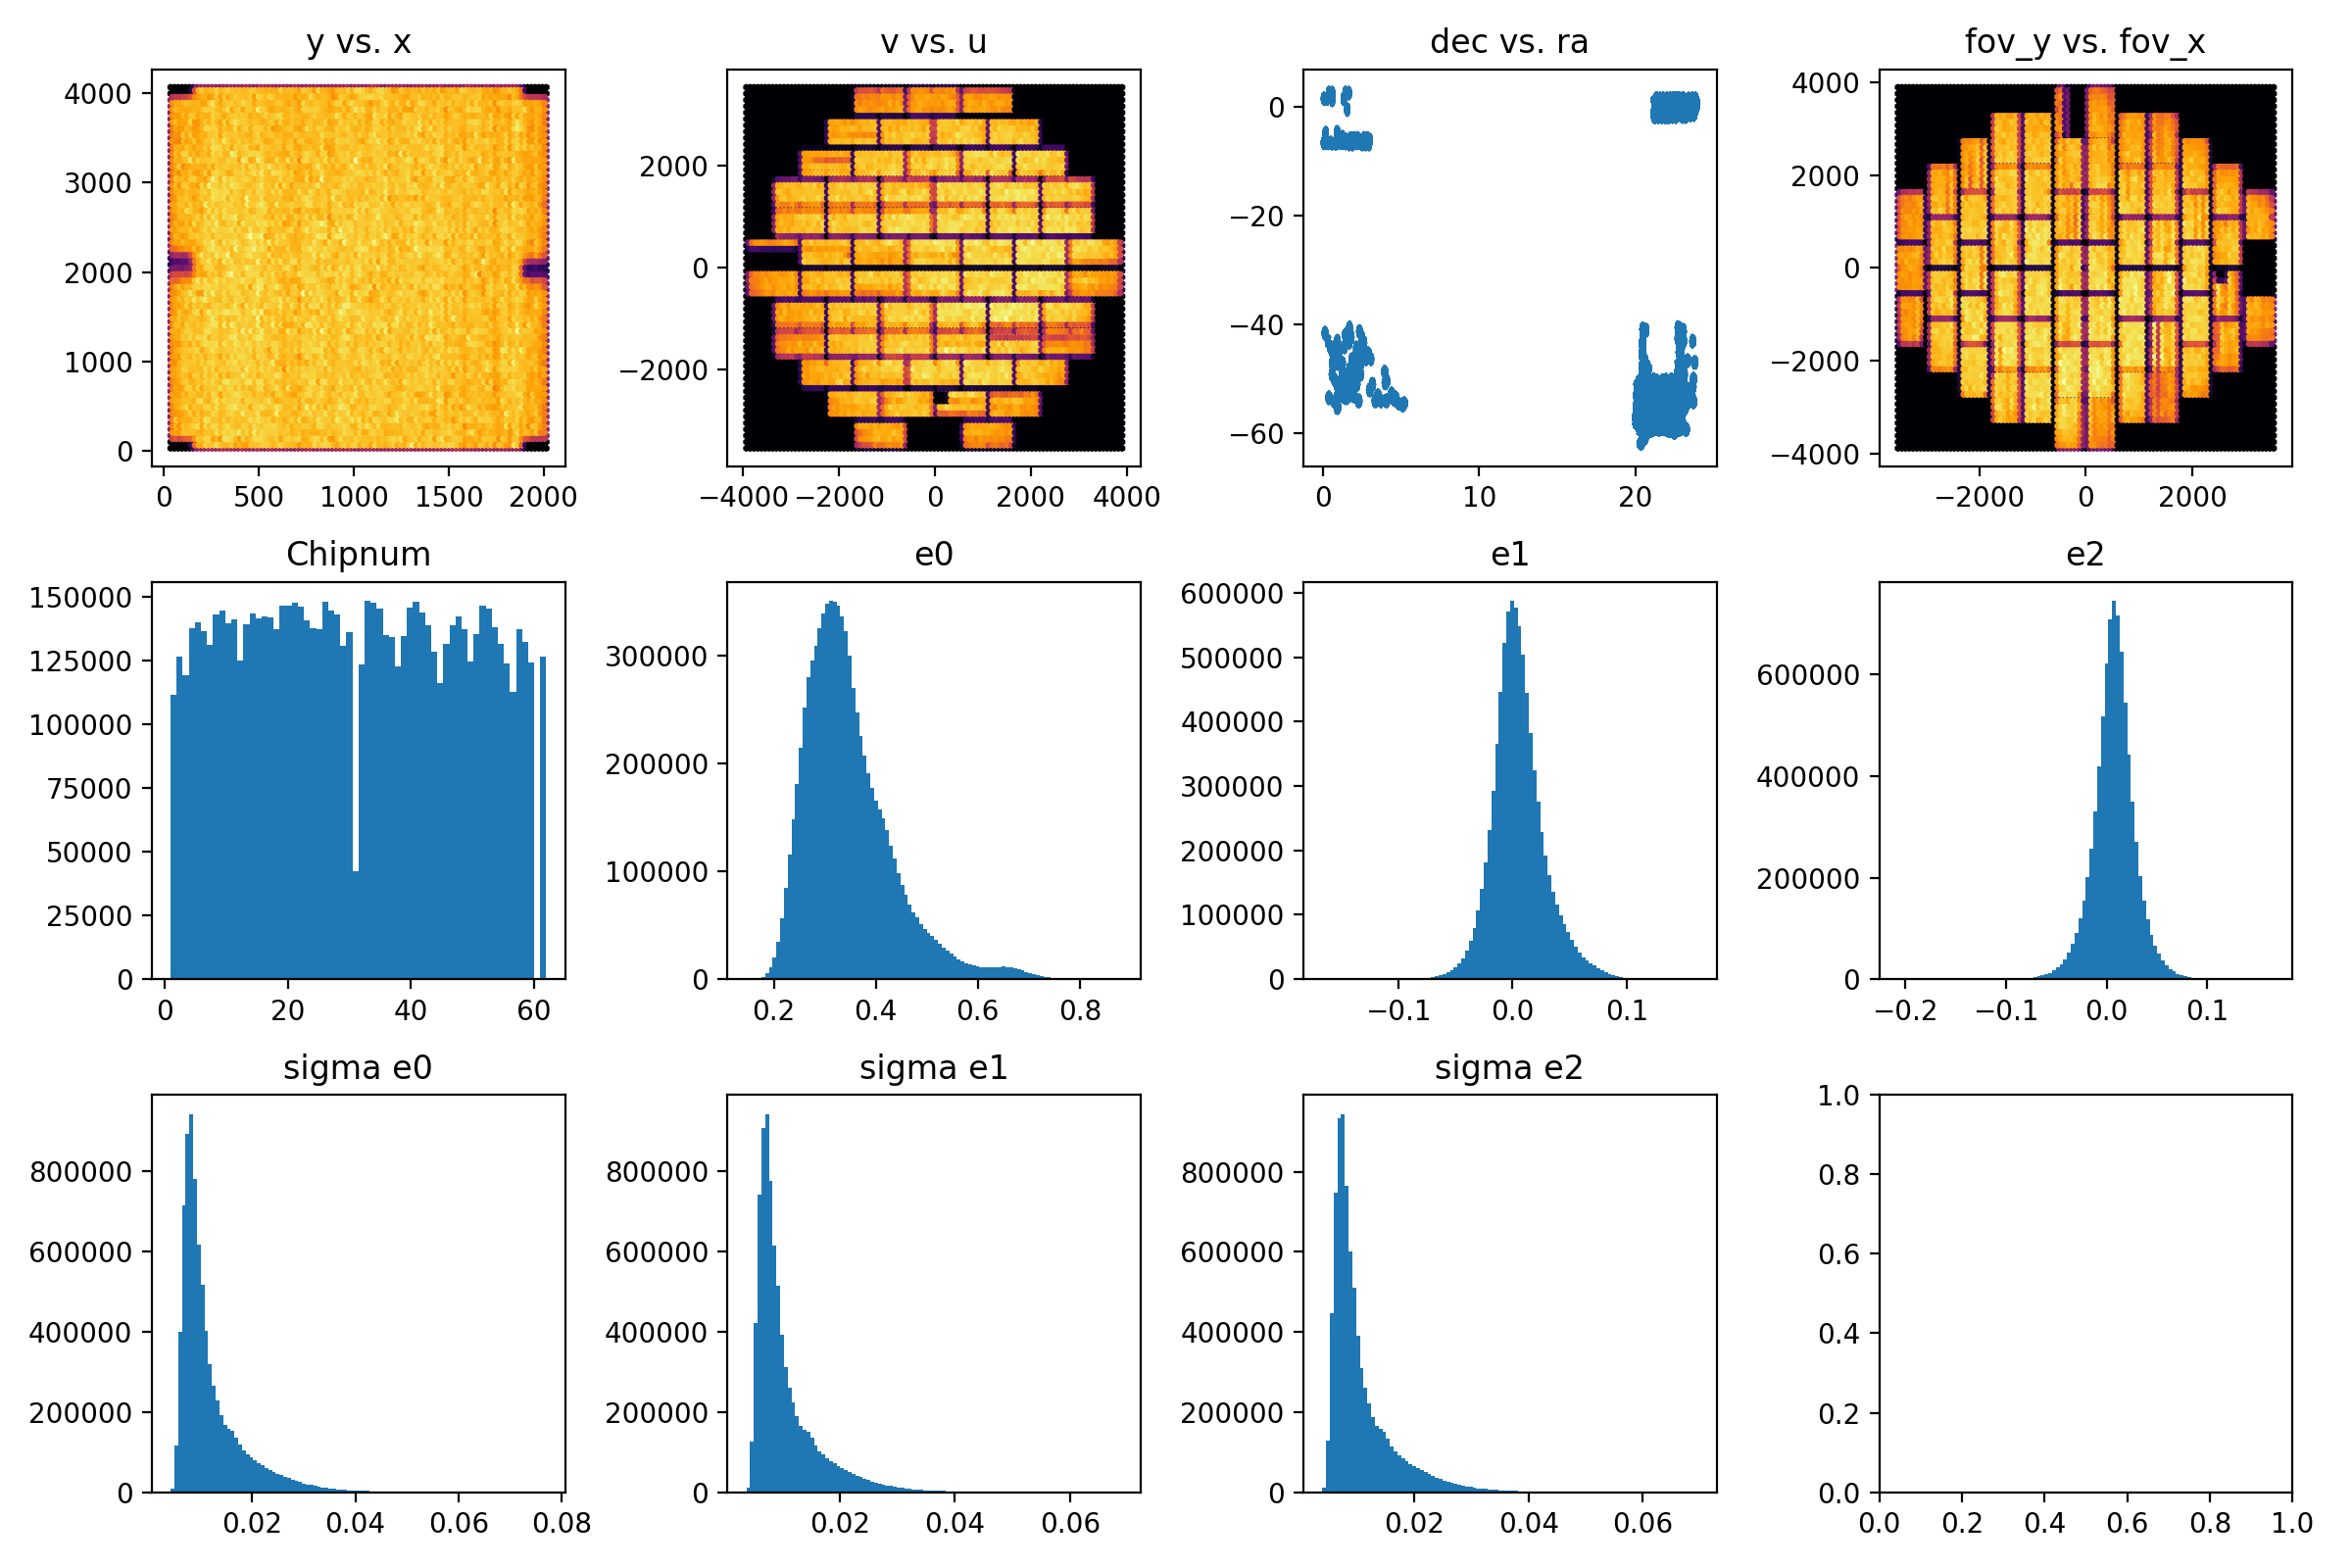

In [23]:
# plot variables for test stars
t = af['psf_stars'].read()

f,axa = plt.subplots(3,4,figsize=(12,8))
ax = axa.flatten()

ax[0].hexbin(t['x'][:],t['y'][:],gridsize=100, cmap='inferno')
ax[0].set_title('y vs. x')
ax[1].hexbin(t['u'][:],t['v'][:],gridsize=100, cmap='inferno') 
ax[1].set_title('v vs. u')
ax[2].scatter(t['ra'][:],t['dec'][:],marker='.',s=0.05)
ax[2].set_title('dec vs. ra')
ax[3].hexbin(t['fov_x'][:],t['fov_y'][:],gridsize=100, cmap='inferno') 
ax[3].set_title('fov_y vs. fov_x')
ax[4].hist(t['chipnum'][:],bins=62)
ax[4].set_title('Chipnum')
ax[5].hist(t['e0'][:],bins=100)
ax[5].set_title('e0')
ax[6].hist(t['e1'][:],bins=100)
ax[6].set_title('e1')
ax[7].hist(t['e2'][:],bins=100)
ax[7].set_title('e2')
ax[8].hist(t['se0'][:],bins=100)
ax[8].set_title('sigma e0')
ax[9].hist(t['se1'][:],bins=100)
ax[9].set_title('sigma e1')
ax[10].hist(t['se2'][:],bins=100)
ax[10].set_title('sigma e2')

plt.tight_layout()